# Capstone Project: Predicting New York Times Cooking Recipe Popularity
### Notebook 02 - EDA and Data Preprocessing


_Author: Joe Serigano (jserigano4@gmail.com)_

---

**Objectives:**
- Perform EDA on recipe data to gain insight of recipe popularity based on certain features.
- One-hot encode certain textual features that will be leveraged for modeling purposes.
- Export cleaned data for modelling.

The main question we are trying to answer is: **What characteristics of a recipe are most likely to increase the popularity (and overall site traffic), and what changes can be made to increase recipe popularity before posting?**

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# We are dealing with large data sets, so setting max number of column and row displays to be unlimited
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
recipes = pd.read_csv('data/recipes_cleaned_data.csv')
recipes.drop(columns = ['Unnamed: 0'], inplace = True)
recipes.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat oven to 425 degrees. In a large bowl, com...",7.0,2 tablespoons peeled and minced ginger1 tables...,3271,"fish sauce, ginger, ground pork, ritz crackers...",vietnamese,"dinner, lunch, weekday, weeknight, meatballs, ...",5.0,119,49,7
4,https://cooking.nytimes.com/recipes/1023380-ba...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Basil and Tomato Fried Rice,Hetty McKinnon,2022-08-01,Summer’s dynamic duo of tomato and basil make ...,15.0,4 servings,5.0,"In a bowl, whisk the eggs with 1/2 teaspoon sa...",10.0,4 eggsKosher salt (such as Diamond Crystal) an...,136,"basil, egg, rice, tomatoes, summer, vegetarian",NaN,"dinner, easy, lunch, quick, weekday, grains an...",4.0,99,234,5


First, let's look at the number of recipes per rating:

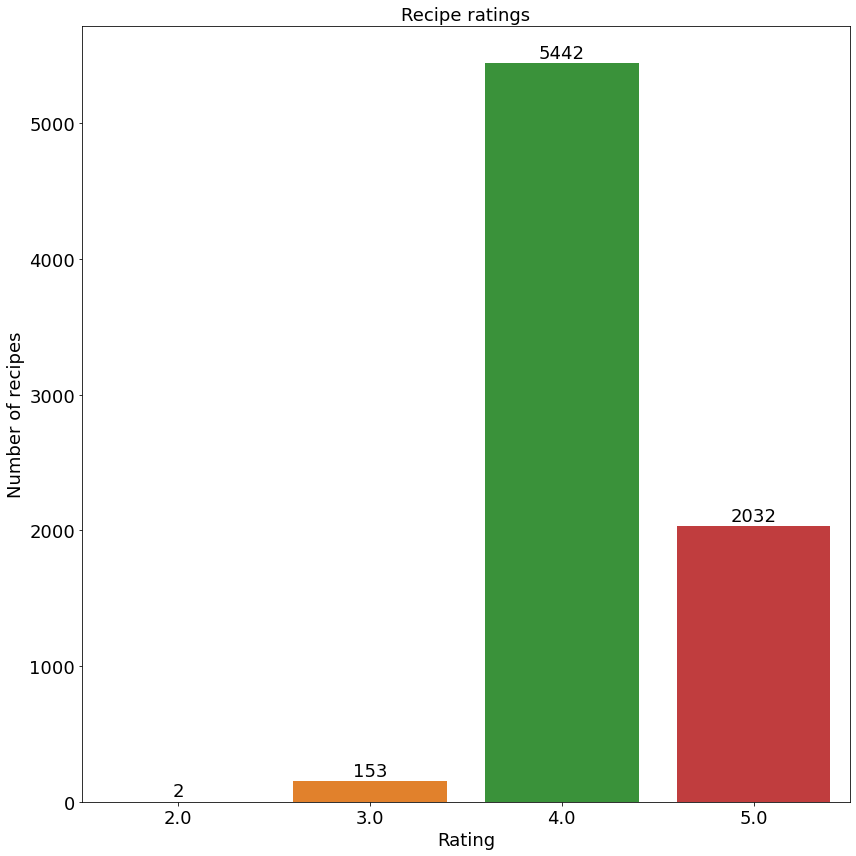

In [3]:
fsize = 18

plt.figure(figsize = (12,12))

ax = sns.countplot(x='rating', data=recipes)
ax.set_title('Recipe ratings', fontsize=fsize)
ax.set_xlabel('Rating', fontsize=fsize)
ax.set_ylabel('Number of recipes', fontsize=fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize)

for p in ax.patches:
    ax.annotate(np.round(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()),ha='center', va='center', xytext=(0, 10),textcoords='offset points', fontsize = fsize)

plt.tight_layout()
plt.savefig('figures/n_ratings.png',facecolor = 'white');

Unfortunately, NYT Cooking must delete all recipes that do not do well, leaving mostly recipes with 4 and 5 star reviews. There are only 2 recipes that fall below 3 stars. Let's look further into this:

In [4]:
rating = recipes[recipes['rating'] == 2.0]
rating[['recipe_url','title']].head()

,recipe_url,title
2850,https://cooking.nytimes.com/recipes/12404-viet...,Vietnamese-Style Soup With Broccoli and Quinoa
6945,https://cooking.nytimes.com/recipes/1213-swedi...,Swedish “S” Cookies


Looking through the comments on these two recipes:

- Vietnamese-Style Soup With Broccoli and Quinoa: Many people found this Americanized version of pho disrespectful to the Vietnamese culture, resulting in many negative comments and reviews.
- Swedish "S" cookies: This recipe has incorrect ingredient proportions that were never fixed, leading to negative comments and reviews.

It's possible these two recipes slipped through the cracks and were never dealt with appropriately and taken down by NYT Cooking. Since they are outliers in this data set, we will remove them.

In [5]:
recipes = recipes[recipes['rating'] > 2.0]
recipes.shape

(7627, 20)

Next, let's look at how average rating corresponds to overall number of ratings:

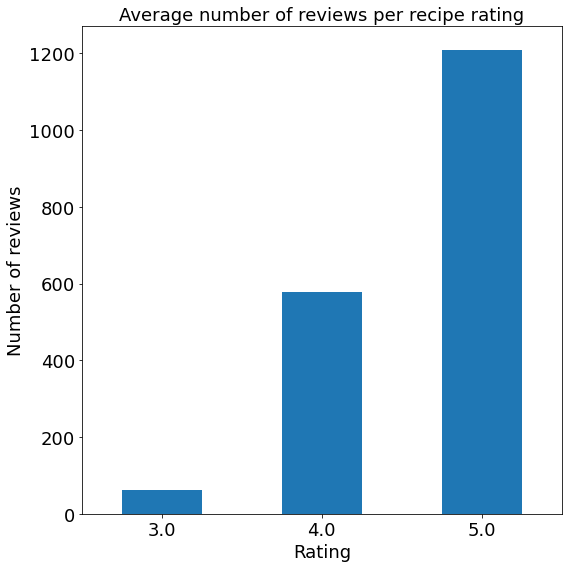

In [6]:
plt.figure(figsize = (8,8))
recipes.groupby('rating')['rating_count'].mean().plot(kind = 'bar')
plt.title('Average number of reviews per recipe rating', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.xticks(rotation=0)
plt.yticks(fontsize = fsize)
plt.xlabel('Rating',fontsize = fsize);
plt.ylabel('Number of reviews',fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/avg_n_reviews.png',facecolor = 'white')

It appears that rating and number of reviews per recipe are highly correlated. People are more likely to interact with a good recipe! Rating will be a useful feature in our modeling.

Next, we need to clean up some more columns. There are some columns that include incorrect inputs when a feature was unavailabe for a recipe. In particular, the 'tags' and 'category' columns include a quote and comma (",) as an input when no tags or categories are present for a recipe.

In [7]:
recipes['tags'].value_counts().head(5)

",                                                              257
vegetarian                                                       32
vegan, vegetarian                                                26
dairy-free, gluten-free, kosher, nut-free, vegan, vegetarian     13
chicken                                                          11
Name: tags, dtype: int64

In [8]:
recipes['category'].value_counts().head(5)

",                     330
dinner, main course    271
dessert                260
cakes, dessert         177
side dish              137
Name: category, dtype: int64

Instead, we will change these values to 'NA' to indicate that the feature was not available for this recipe.

In [9]:
recipes.loc[recipes['tags'] == '",', 'tags'] = 'NA'
recipes.loc[recipes['category'] == '",', 'category'] = 'NA'

We'll also add separate columns for year, month, and day of week in order to check for any interesting patterns. 

In [10]:
recipes['date'] = pd.to_datetime(recipes['date'])

recipes['year'] = recipes['date'].apply(lambda x: x.year).astype(object)

recipes['month'] = recipes['date'].apply(lambda x: x.month).astype(object)

recipes['day'] = recipes['date'].apply(lambda x: x.day_name()).astype(object)

In [11]:
recipes.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount,year,month,day
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3,2022,8,Saturday
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6,2022,8,Saturday
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6,2022,8,Saturday
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat oven to 425 degrees. In a large bowl, com...",7.0,2 tablespoons peeled and minced ginger1 tables...,3271,"fish sauce, ginger, ground pork, ritz crackers...",vietnamese,"dinner, lunch, weekday, weeknight, meatballs, ...",5.0,119,49,7,2018,11,Friday
4,https://cooking.nytimes.com/recipes/1023380-ba...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Basil and Tomato Fried Rice,Hetty McKinnon,2022-08-01,Summer’s dynamic duo of tomato and basil make ...,15.0,4 servings,5.0,"In a bowl, whisk the eggs with 1/2 teaspoon sa...",10.0,4 eggsKosher salt (such as Diamond Crystal) an...,136,"basil, egg, rice, tomatoes, summer, vegetarian",NaN,"dinner, easy, lunch, quick, weekday, grains an...",4.0,99,234,5,2022,8,Monday


Next, we'll use a modified version of an EDA function created by [Katie Sylvia](https://towardsdatascience.com/easy-breezy-eda-updated-function-using-seaborn-ffe2ccc9f56a) to create some initial figures and get a better sense of the distribution of certain features:

In [12]:
def initial_eda(df):
    # List of categorical columns
    cat_cols = df.select_dtypes(['object','category']).columns
    
    for col in cat_cols:
        # Formatting
        column_name = col.title().replace('_', ' ')
        title = 'Distribution of ' + column_name
        unique_values = len(df[col].value_counts())
        
        # If statements for figsize
        if 2<=unique_values<3: 
            plt.figure(figsize = (12, 8))
            sns.countplot(x=df[col], 
                          data=df, 
                          palette="Paired",
                          order = df[col].value_counts().index)
            plt.title(title, fontsize = 18, pad = 12)
            plt.xlabel(column_name, fontsize = 15)
            plt.xticks(rotation=20)
            plt.ylabel("Frequency",fontsize = 15)
           # plt.show();
        elif 3<=unique_values<8:
            plt.figure(figsize = (12, 8))
            sns.countplot(x=df[col], 
                          data=df, 
                          palette="Paired",
                          order = df[col].value_counts().index)
            plt.title(title, fontsize = 18, pad = 12)
            plt.xlabel(column_name, fontsize = 15)
            plt.xticks(rotation=20)
            plt.ylabel("Frequency",fontsize = 15)
            #plt.show();
        elif 8<=unique_values<=12:
            plt.figure(figsize = (12, 8))
            sns.countplot(x=df[col], 
                          data=df, 
                          palette="Paired",
                          order = df[col].value_counts().index)
            plt.title(title, fontsize = 18, pad = 12)
            plt.xlabel(column_name, fontsize = 15)
            plt.xticks(rotation=20)
            plt.ylabel("Frequency",fontsize = 15)
            #plt.show();
        else:
            print(f'{column_name} has {len(df[col].value_counts())} unique values. Here are the top 15:')
            print()
            col_count  = df[col].value_counts()
            col_count = col_count[:15,]
            plt.figure(figsize = (12, 8))
            sns.barplot(x = col_count.index, 
                        y = col_count.values, 
                        palette="Paired")
            plt.title(f'Top 15: {column_name}', fontsize = 18, pad = 12)
            plt.ylabel('Frequency', fontsize=15)
            plt.xticks(rotation=45)
            plt.xlabel(column_name, fontsize=15)
        
        plt.tight_layout();
        fig_name = 'figures/' + 'top15_'+ column_name + '.png'
        plt.savefig(fig_name,facecolor = 'white')
            
    return

In [13]:
eda_columns = ['author', 'date', 'yields', 'cuisine', 'category', 'year', 'month', 'day']
recipes_eda = recipes[eda_columns]

Author has 292 unique values. Here are the top 15:

Yields has 75 unique values. Here are the top 15:

Cuisine has 146 unique values. Here are the top 15:

Category has 2390 unique values. Here are the top 15:

Year has 19 unique values. Here are the top 15:



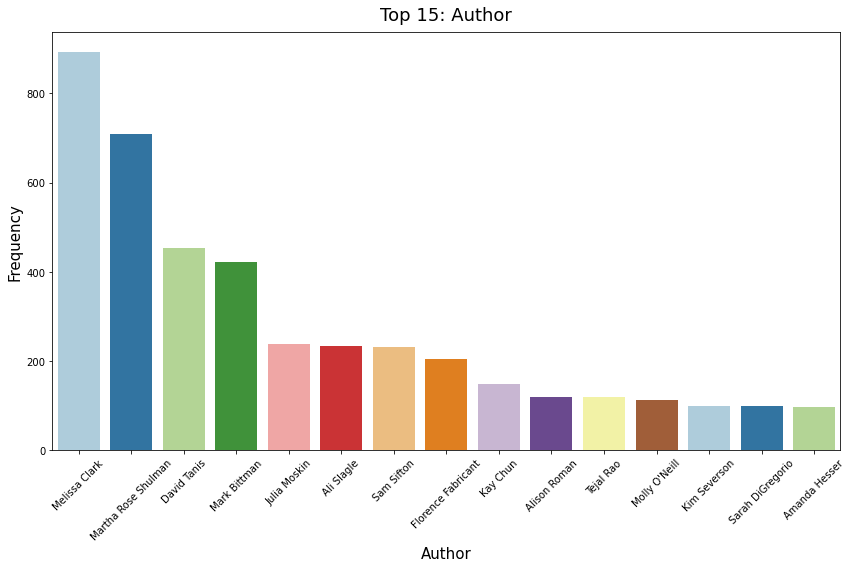

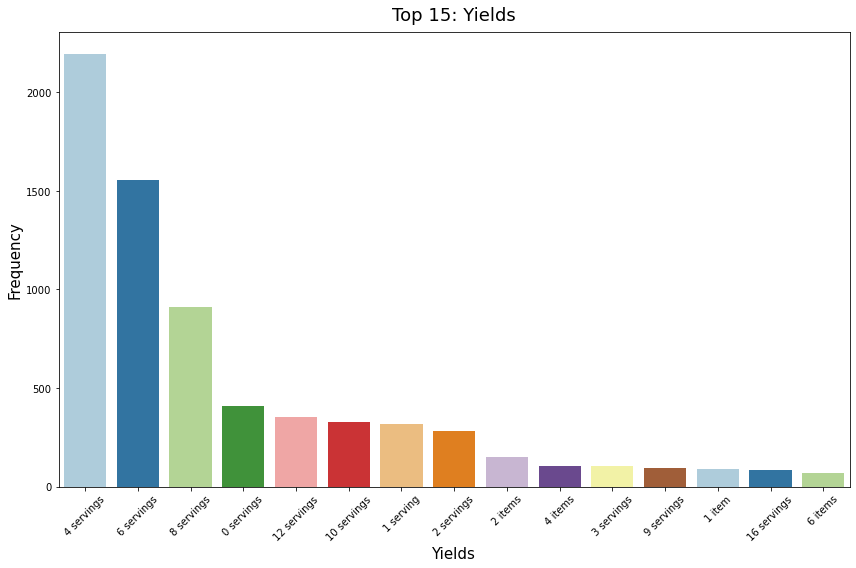

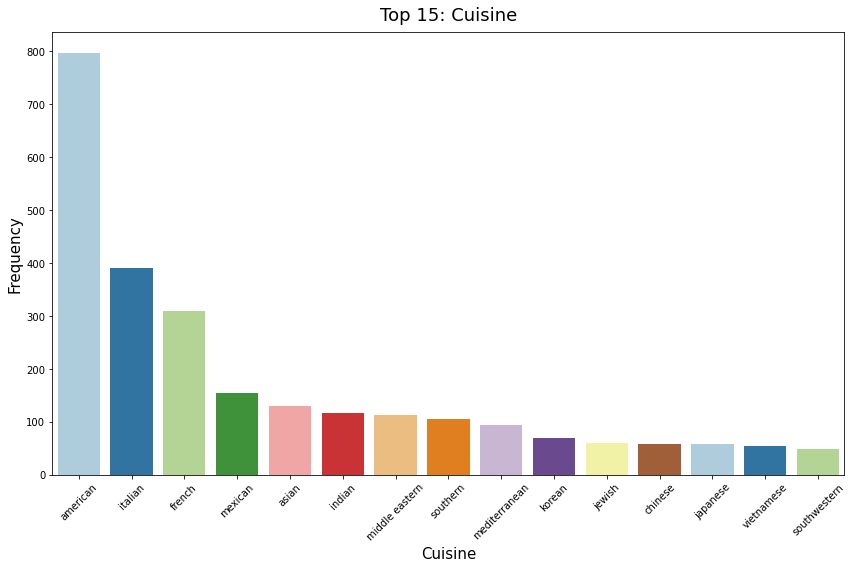

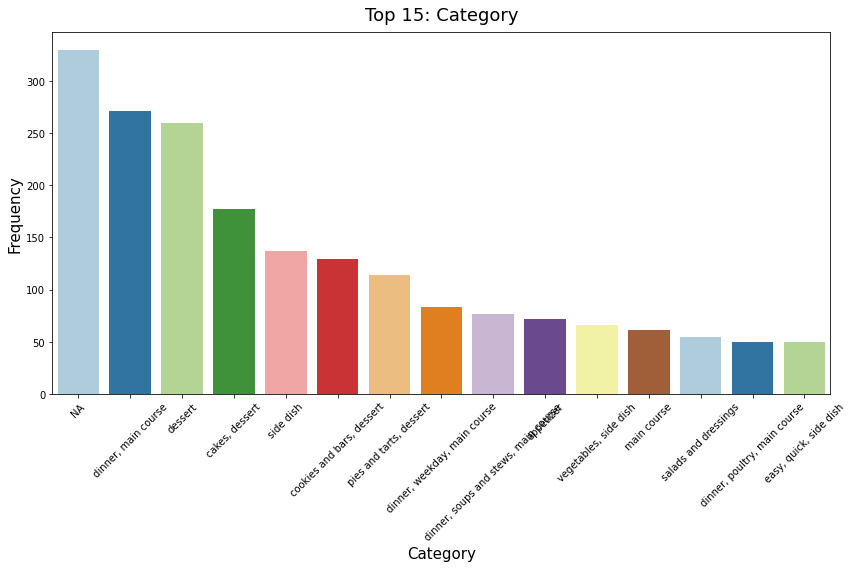

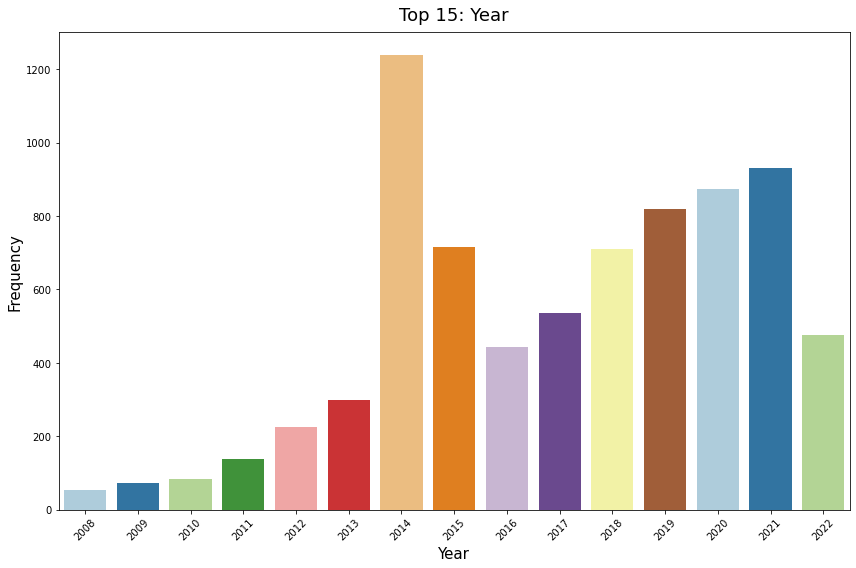

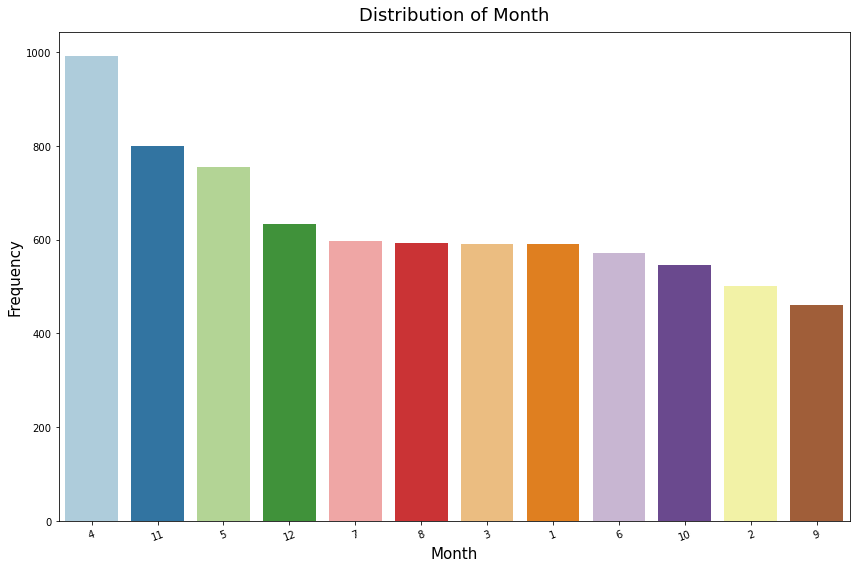

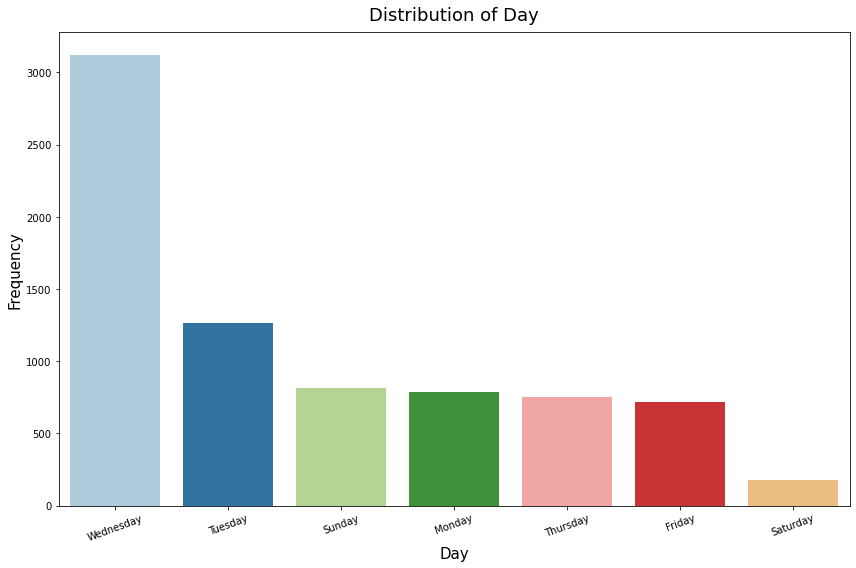

In [14]:
initial_eda(recipes_eda)

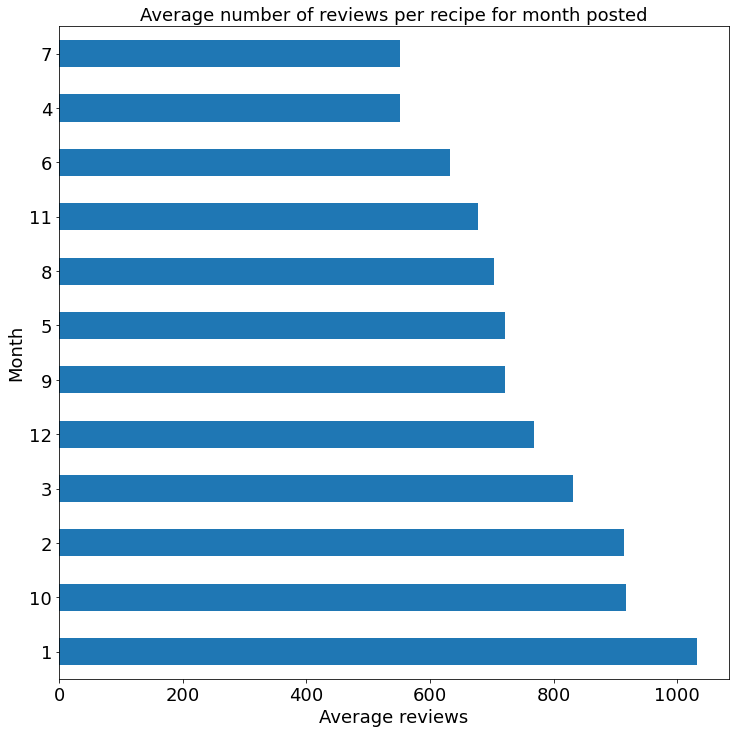

In [15]:
plt.figure(figsize = (12,12))

recipes.groupby('month')['rating_count'].mean().sort_values(ascending=False).plot(kind = 'barh');
plt.title('Average number of reviews per recipe for month posted', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize)
plt.xlabel('Average reviews',fontsize = fsize);
plt.ylabel('Month',fontsize = fsize);

/Users/jserigano4/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


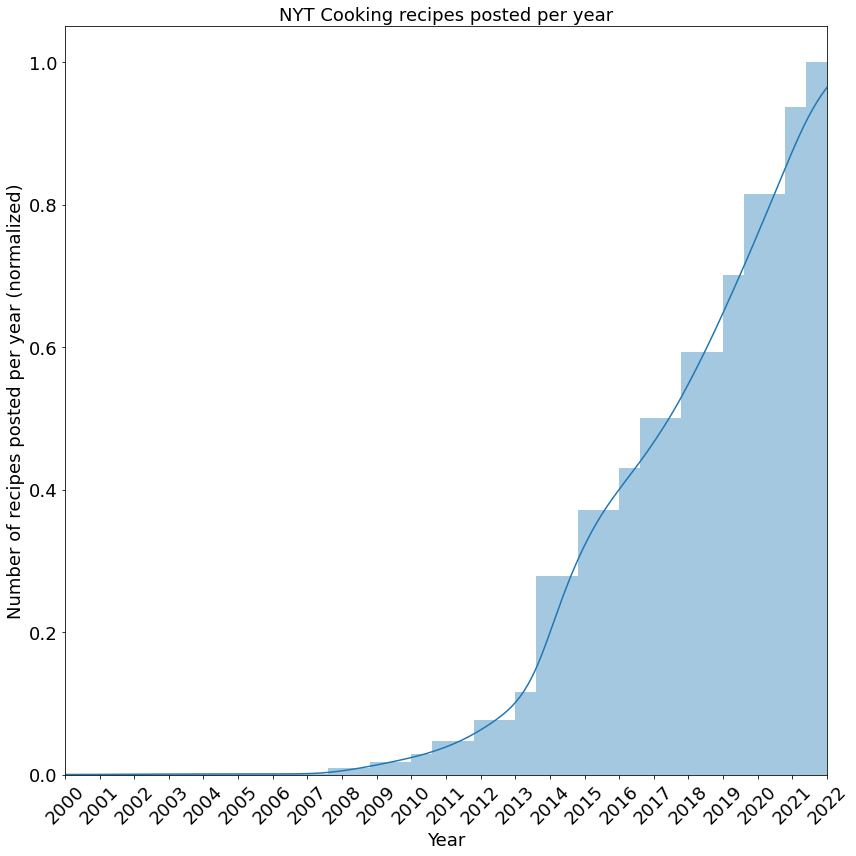

In [16]:
plt.figure(figsize = (12,12))
kwargs = {'cumulative': True}
sns.distplot(recipes['year'], hist_kws=kwargs, kde_kws=kwargs, norm_hist = True)
plt.xlim([2000, 2022])
plt.xticks(np.arange(2000, 2023, 1), fontsize = fsize, rotation = 45)
plt.yticks(fontsize = fsize)
plt.ylabel('Number of recipes posted per year (normalized)', fontsize = fsize)
plt.xlabel('Year', fontsize=fsize)
plt.title('NYT Cooking recipes posted per year', fontsize = fsize)
plt.tight_layout();
plt.savefig('figures/recipes_per_year.png',facecolor = 'white')

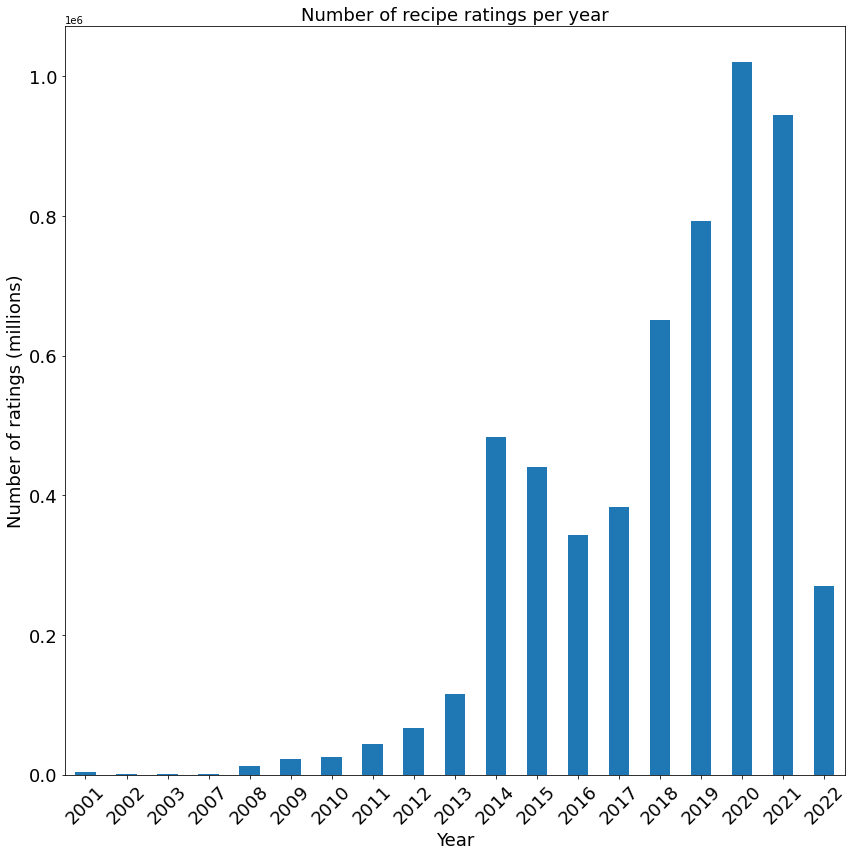

In [17]:
plt.figure(figsize = (12,12))

recipes.groupby('year')['rating_count'].sum().plot(kind = 'bar')
plt.title('Number of recipe ratings per year', fontsize = fsize)
plt.xticks(fontsize = fsize, rotation = 45)
plt.yticks(fontsize = fsize)
plt.xlabel('Year',fontsize = fsize);
plt.ylabel('Number of ratings (millions)',fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_ratings_per_year.png',facecolor = 'white')

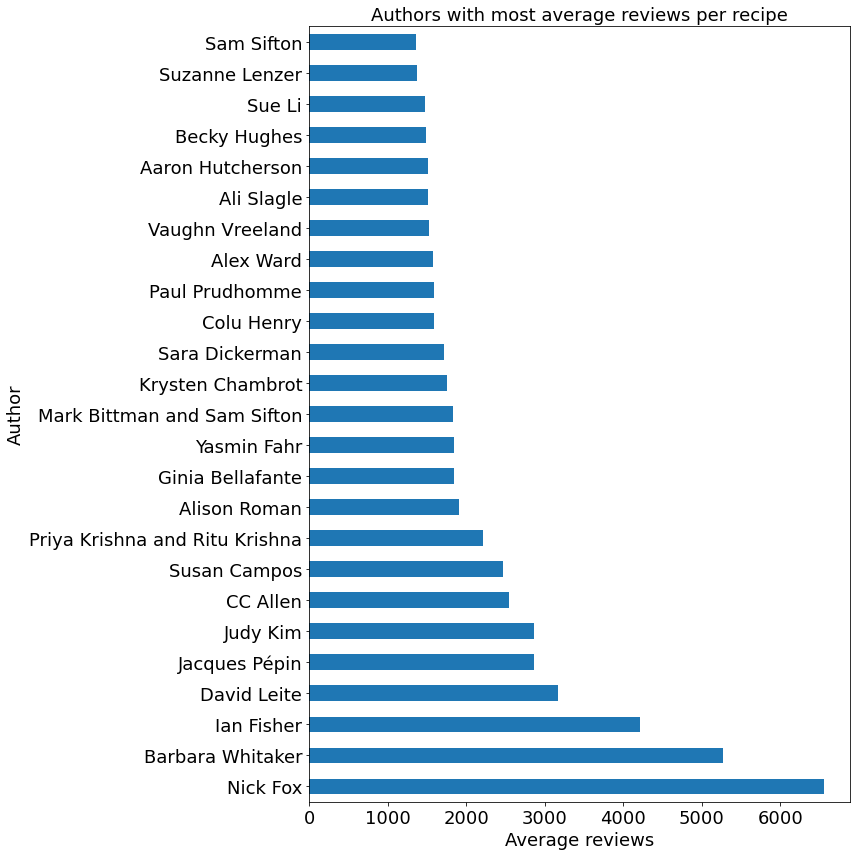

In [18]:
plt.figure(figsize = (12,12))

recipes.groupby('author')['rating_count'].mean().sort_values(ascending=False).head(25).plot(kind = 'barh')
plt.title('Authors with most average reviews per recipe', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize)
plt.xlabel('Average reviews',fontsize = fsize);
plt.ylabel('Author',fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_recipes_per_authors_boxplot.png',facecolor = 'white')

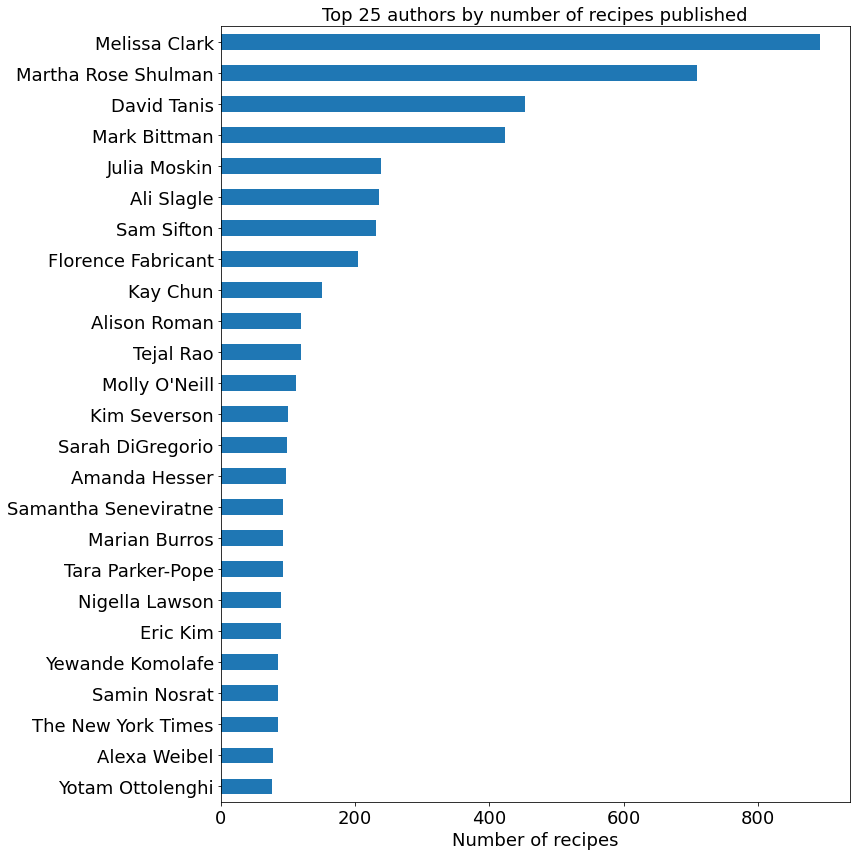

In [19]:
fsize = 18
plt.figure(figsize = (12,12))
recipes['author'].value_counts(ascending = True)[recipes['author'].value_counts()>75].plot(kind = 'barh', fontsize = fsize)
plt.title('Top 25 authors by number of recipes published', fontsize = fsize)
plt.xlabel('Number of recipes', fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/top_25_authors.png',facecolor = 'white')

The average author publises 26 recipes on NYT Cooking, however there are many outliers with a substantial amount of publications. This include Melissa Clark, the "Queen of NYT Cooking," with over 800 recipes!

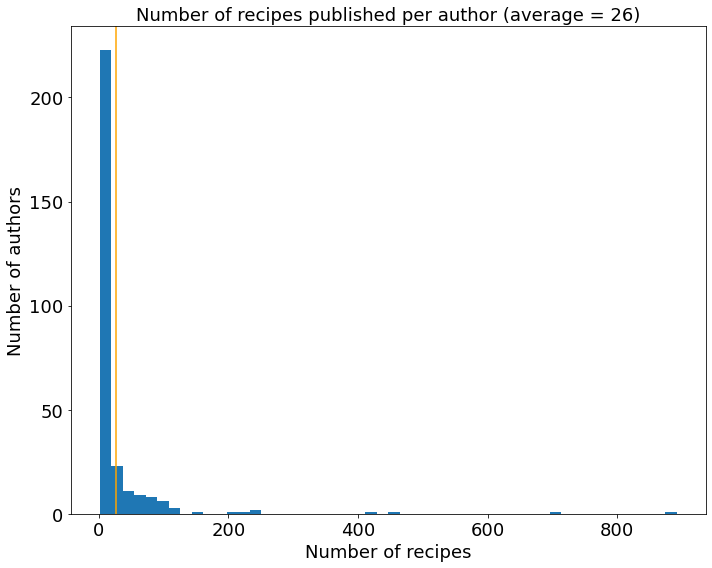

In [20]:
mean = recipes['author'].value_counts().mean()
plt.figure(figsize = (10,8))
recipes['author'].value_counts().hist(bins = 50,grid = False)
plt.axvline(mean, color = 'orange')
plt.xlabel('Number of recipes', fontsize = fsize)
plt.ylabel('Number of authors', fontsize = fsize)
plt.title(f'Number of recipes published per author (average = {round(mean)})', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_recipes_per_authors_hist.png',facecolor = 'white')

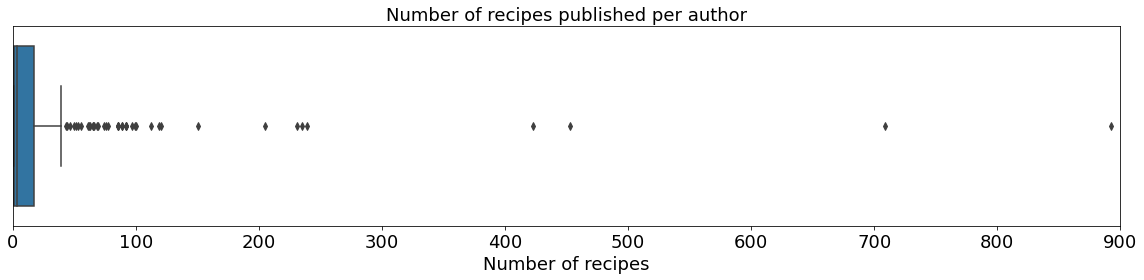

In [21]:
# There are a few extreme outliers in our data
plt.figure(figsize=(16,4))
sns.boxplot(data=recipes['author'].value_counts(), orient='h')
plt.yticks([])
plt.xticks(fontsize = fsize)
plt.xlim([0, 900])
plt.title('Number of recipes published per author', fontsize = fsize)
plt.xlabel('Number of recipes', fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_recipes_per_authors_boxplot.png',facecolor = 'white')

Looking at a few more metrics, average word count of recipe description and number of steps per recipes are relatively normally distributed with some outliers on the higher end.

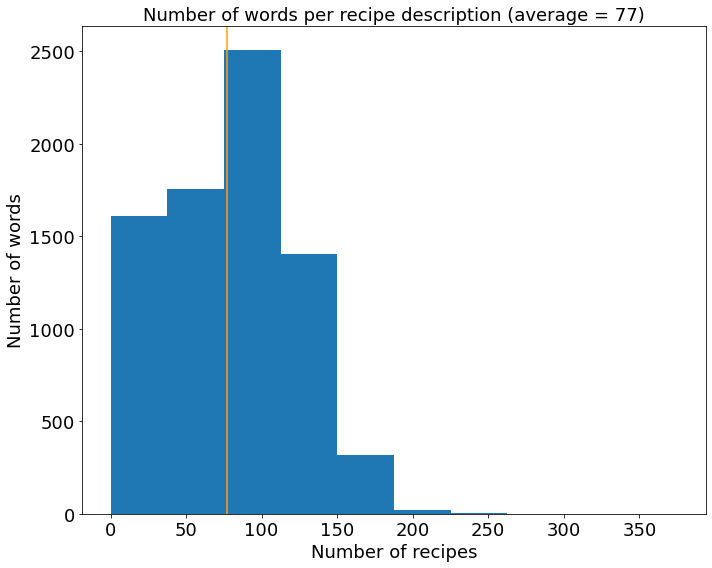

In [22]:
mean = round(recipes['description_wordcount'].mean())
plt.figure(figsize = (10,8))
plt.hist(recipes['description_wordcount'])
plt.axvline(recipes['description_wordcount'].mean(), color = 'orange')
plt.xlabel('Number of recipes', fontsize = fsize)
plt.ylabel('Number of words', fontsize = fsize)
plt.title(f'Number of words per recipe description (average = {mean})', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_descriptionwords_hist.png',facecolor = 'white')

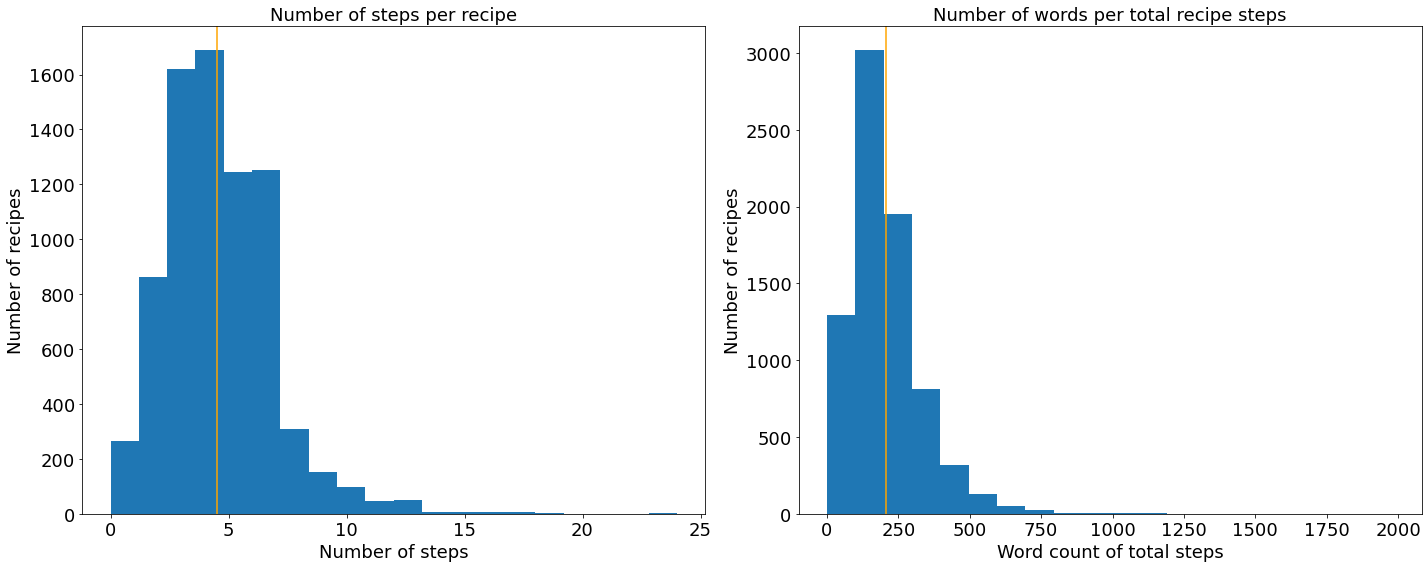

In [23]:
plt.figure(figsize = (20,8))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(recipes['n_steps'],bins=20)
plt.axvline(recipes['n_steps'].mean(), color = 'orange')
ax1.set_xlabel('Number of steps', fontsize = fsize)
ax1.set_ylabel('Number of recipes', fontsize = fsize)
plt.title('Number of steps per recipe', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

ax2 = plt.subplot(1, 2, 2)
ax2.hist(recipes['steps_wordcount'],bins=20)
plt.axvline(recipes['steps_wordcount'].mean(), color = 'orange')
ax2.set_xlabel('Word count of total steps', fontsize = fsize)
ax2.set_ylabel('Number of recipes', fontsize = fsize)
plt.title('Number of words per total recipe steps', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/n_steps_hist.png',facecolor = 'white')

In [24]:
recipes.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount,year,month,day
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3,2022,8,Saturday
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6,2022,8,Saturday
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6,2022,8,Saturday
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat oven to 425 degrees. In a large bowl, com...",7.0,2 tablespoons peeled and minced ginger1 tables...,3271,"fish sauce, ginger, ground pork, ritz crackers...",vietnamese,"dinner, lunch, weekday, weeknight, meatballs, ...",5.0,119,49,7,2018,11,Friday
4,https://cooking.nytimes.com/recipes/1023380-ba...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Basil and Tomato Fried Rice,Hetty McKinnon,2022-08-01,Summer’s dynamic duo of tomato and basil make ...,15.0,4 servings,5.0,"In a bowl, whisk the eggs with 1/2 teaspoon sa...",10.0,4 eggsKosher salt (such as Diamond Crystal) an...,136,"basil, egg, rice, tomatoes, summer, vegetarian",NaN,"dinner, easy, lunch, quick, weekday, grains an...",4.0,99,234,5,2022,8,Monday


## Tags
---

The ingredients column is very messy and includes a lot of unnecessary information. Additionally, separating this feature into multiple sub-features would likely lead to an overfit model in the end that wouldn't work well on unseen data. Instead of using the 'ingredients' column as a feature, we will use the 'tags' column, which includes the key ingredients for each recipe. First, we'll modify the tags into a list for each recipe and then do some EDA to determine which tags seem like useful features.

In [25]:
recipes['tag_list'] = [x.split(',') for x in recipes['tags']]

In [26]:
recipes.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount,year,month,day,tag_list
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3,2022,8,Saturday,"[apricot, melon, nectarine]"
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6,2022,8,Saturday,"[green beans, herbs, lamb shoulder]"
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6,2022,8,Saturday,"[eggplant, lavash, tomato, summer, vegetar..."
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat oven to 425 degrees. In a large bowl, com...",7.0,2 tablespoons peeled and minced ginger1 tables...,3271,"fish sauce, ginger, ground pork, ritz crackers...",vietnamese,"dinner, lunch, weekday, weeknight, meatballs, ...",5.0,119,49,7,2018,11,Friday,"[fish sauce, ginger, ground pork, ritz crac..."
4,https://cooking.nytimes.com/recipes/1023380-ba...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Basil and Tomato Fried Rice,Hetty McKinnon,2022-08-01,Summer’s dynamic duo of tomato and basil make ...,15.0,4 servings,5.0,"In a bowl, whisk the eggs with 1/2 teaspoon sa...",10.0,4 eggsKosher salt (such as Diamond Crystal) an...,136,"basil, egg, rice, tomatoes, summer, vegetarian",NaN,"dinner, easy, lunch, quick, weekday, grains an...",4.0,99,234,5,2022,8,Monday,"[basil, egg, rice, tomatoes, summer, vege..."


In [27]:
recipes.shape

(7627, 24)

We'll create a new DataFrame to explore the tags:

In [28]:
recipes_tag = pd.concat([recipes.drop(columns = 'tag_list'), pd.get_dummies(recipes['tag_list'].apply(pd.Series),
                                                      prefix='tag')], axis=1)

In [29]:
recipes_tag.shape

(7627, 6265)

This created 6241 unique tags, many of which we'll need to remove in order to not overwhelm the model. Ideally, only tags that are commonly used among many recipes should be used in our model. We'll drop all tags that occur in less than 15 recipes.

In [30]:
recipes_tag.drop([col for col, val in recipes_tag.sum(numeric_only = True).iteritems() if val < 15], axis=1, inplace=True)
recipes_tag.shape

(7627, 133)

This gets rid of 6108 tags, leaving us with the 109 most popular tags to include as features in our model. 

In [31]:
recipes_tag.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount,year,month,day,tag_NA,tag_active dry yeast,tag_all-purpose flour,tag_almond,tag_almond extract,tag_almond flour,tag_almonds,tag_anchovies,tag_anchovy,tag_anchovy fillets,tag_apple,tag_apricot,tag_arborio rice,tag_arugula,tag_asparagus,tag_avocado,tag_bacon,tag_balsamic vinegar,tag_banana,tag_basil,tag_basmati rice,tag_beef,tag_beer,tag_beet,tag_beets,tag_bell pepper,tag_berries,tag_birthday,tag_bittersweet chocolate,tag_black beans,tag_black pepper,tag_blackberries,tag_blue cheese,tag_blueberries,tag_bok choy,tag_bourbon,tag_bread,tag_bread crumbs,tag_bread flour,tag_broccoli,tag_broccoli rabe,tag_brown sugar,tag_brussels sprouts,tag_butter,tag_buttermilk,tag_butternut squash,tag_cabbage,tag_canned tomatoes,tag_cannellini beans,tag_capers,tag_cardamom,tag_carrot,tag_cauliflower,tag_celery,tag_cheddar,tag_cheese,tag_cherries,tag_cherry tomatoes,tag_chicken,tag_chicken breast,tag_chicken stock,tag_chicken thigh,tag_chicken thighs,tag_chickpea,tag_chives,tag_chocolate,tag_chocolate chips,tag_christmas,tag_cilantro,tag_cinnamon,tag_clams,tag_cocoa powder,tag_coconut milk,tag_cod,tag_corn,tag_corn tortillas,tag_cornmeal,tag_cream,tag_cream cheese,tag_cucumber,tag_cumin,tag_dairy-free,tag_dijon mustard,tag_dill,tag_easter,tag_egg,tag_eggplant,tag_eggs,tag_fall,tag_father’s day,tag_fennel,tag_feta,tag_fish,tag_fish sauce,tag_flour,tag_fourth of july,tag_garlic,tag_ginger,tag_gluten-free,tag_ground beef,tag_healthy,tag_heavy cream,tag_lamb,tag_lemon,tag_mushroom,tag_pasta,tag_summer,tag_vegan,tag_vegetarian,tag_ bell pepper
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat ove

In [32]:
cols = [col for col in recipes_tag.columns if col.lower()[:4] == 'tag_']
tags_only = recipes_tag[cols]

In [33]:
tags_only.head()

,tag_NA,tag_active dry yeast,tag_all-purpose flour,tag_almond,tag_almond extract,tag_almond flour,tag_almonds,tag_anchovies,tag_anchovy,tag_anchovy fillets,tag_apple,tag_apricot,tag_arborio rice,tag_arugula,tag_asparagus,tag_avocado,tag_bacon,tag_balsamic vinegar,tag_banana,tag_basil,tag_basmati rice,tag_beef,tag_beer,tag_beet,tag_beets,tag_bell pepper,tag_berries,tag_birthday,tag_bittersweet chocolate,tag_black beans,tag_black pepper,tag_blackberries,tag_blue cheese,tag_blueberries,tag_bok choy,tag_bourbon,tag_bread,tag_bread crumbs,tag_bread flour,tag_broccoli,tag_broccoli rabe,tag_brown sugar,tag_brussels sprouts,tag_butter,tag_buttermilk,tag_butternut squash,tag_cabbage,tag_canned tomatoes,tag_cannellini beans,tag_capers,tag_cardamom,tag_carrot,tag_cauliflower,tag_celery,tag_cheddar,tag_cheese,tag_cherries,tag_cherry tomatoes,tag_chicken,tag_chicken breast,tag_chicken stock,tag_chicken thigh,tag_chicken thighs,tag_chickpea,tag_chives,tag_chocolate,tag_chocolate chips,tag_christmas,tag_cilantro,tag_cinnamon,tag_clams,tag_cocoa powder,tag_coconut milk,tag_cod,tag_corn,tag_corn tortillas,tag_cornmeal,tag_cream,tag_cream cheese,tag_cucumber,tag_cumin,tag_dairy-free,tag_dijon mustard,tag_dill,tag_easter,tag_egg,tag_eggplant,tag_eggs,tag_fall,tag_father’s day,tag_fennel,tag_feta,tag_fish,tag_fish sauce,tag_flour,tag_fourth of july,tag_garlic,tag_ginger,tag_gluten-free,tag_ground beef,tag_healthy,tag_heavy cream,tag_lamb,tag_lemon,tag_mushroom,tag_pasta,tag_summer,tag_vegan,tag_vegetarian,tag_ bell pepper
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


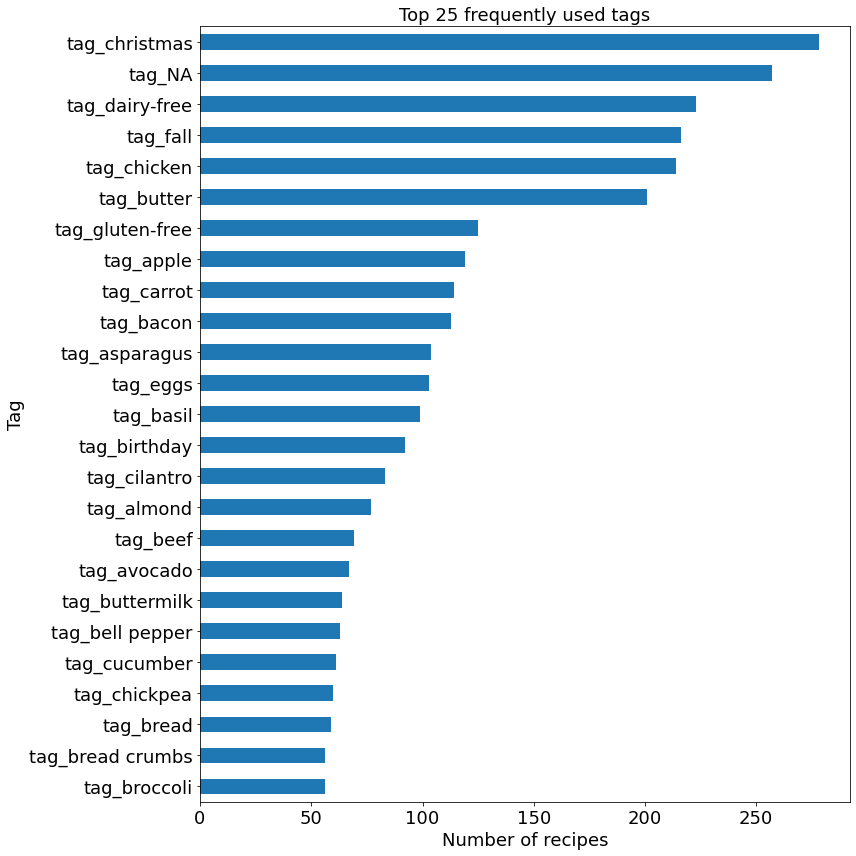

In [34]:
plt.figure(figsize = (12,12))
tags_only.sum(axis = 0, numeric_only = True).sort_values(ascending = True).tail(25).plot(kind = 'barh')
plt.xlabel('Number of recipes', fontsize = fsize)
plt.ylabel('Tag', fontsize = fsize)
plt.title('Top 25 frequently used tags', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);
plt.tight_layout();
plt.savefig('figures/frequent_tags.png',facecolor = 'white')

Now that we've explored the tags, we'll include these into our official recipes DataFrame.

In [35]:
recipes = pd.concat([recipes.drop(columns = 'tag_list'), pd.get_dummies(recipes['tag_list'].apply(pd.Series),
                                                      prefix='tag')], axis=1)
recipes.drop([col for col, val in recipes.sum(numeric_only = True).iteritems() if val < 15], axis=1, inplace=True)
recipes.shape

(7627, 133)

## Categories
---

Next, we'll do a similar exploration of categories. The categories column is not as comprehensive and includes specific keywords for some recipes but not others. Consequently, using all of these will not be useful for our model. Instead, we'll choose only the categories that are best suited for modeling purposes. These include some of the most popular categories as well as unique categories such as seafood.

In [36]:
recipes['is_breakfast'] = recipes['category'].apply(lambda x: 1 if 'breakfast' in x else 0)
recipes['is_brunch'] = recipes['category'].apply(lambda x: 1 if 'brunch' in x else 0)
recipes['is_lunch'] = recipes['category'].apply(lambda x: 1 if 'lunch' in x else 0)
recipes['is_dinner'] = recipes['category'].apply(lambda x: 1 if 'dinner' in x else 0)
recipes['is_dessert'] = recipes['category'].apply(lambda x: 1 if 'dessert' in x else 0)
recipes['is_sidedish'] = recipes['category'].apply(lambda x: 1 if 'side dish' in x else 0)
recipes['is_easy'] = recipes['category'].apply(lambda x: 1 if 'easy' in x else 0)
recipes['is_quick'] = recipes['category'].apply(lambda x: 1 if 'quick' in x else 0)
recipes['is_seafood'] = recipes['category'].apply(lambda x: 1 if 'seafood' in x else 0)
recipes['is_pasta'] = recipes['category'].apply(lambda x: 1 if 'pasta' in x else 0)

In [37]:
recipes.shape

(7627, 143)

In [38]:
recipes_tag.head()

,recipe_url,scraped,title,author,date,description,total_time,yields,n_steps,steps,n_ingredients,ingredients,rating_count,tags,cuisine,category,rating,description_wordcount,steps_wordcount,title_wordcount,year,month,day,tag_NA,tag_active dry yeast,tag_all-purpose flour,tag_almond,tag_almond extract,tag_almond flour,tag_almonds,tag_anchovies,tag_anchovy,tag_anchovy fillets,tag_apple,tag_apricot,tag_arborio rice,tag_arugula,tag_asparagus,tag_avocado,tag_bacon,tag_balsamic vinegar,tag_banana,tag_basil,tag_basmati rice,tag_beef,tag_beer,tag_beet,tag_beets,tag_bell pepper,tag_berries,tag_birthday,tag_bittersweet chocolate,tag_black beans,tag_black pepper,tag_blackberries,tag_blue cheese,tag_blueberries,tag_bok choy,tag_bourbon,tag_bread,tag_bread crumbs,tag_bread flour,tag_broccoli,tag_broccoli rabe,tag_brown sugar,tag_brussels sprouts,tag_butter,tag_buttermilk,tag_butternut squash,tag_cabbage,tag_canned tomatoes,tag_cannellini beans,tag_capers,tag_cardamom,tag_carrot,tag_cauliflower,tag_celery,tag_cheddar,tag_cheese,tag_cherries,tag_cherry tomatoes,tag_chicken,tag_chicken breast,tag_chicken stock,tag_chicken thigh,tag_chicken thighs,tag_chickpea,tag_chives,tag_chocolate,tag_chocolate chips,tag_christmas,tag_cilantro,tag_cinnamon,tag_clams,tag_cocoa powder,tag_coconut milk,tag_cod,tag_corn,tag_corn tortillas,tag_cornmeal,tag_cream,tag_cream cheese,tag_cucumber,tag_cumin,tag_dairy-free,tag_dijon mustard,tag_dill,tag_easter,tag_egg,tag_eggplant,tag_eggs,tag_fall,tag_father’s day,tag_fennel,tag_feta,tag_fish,tag_fish sauce,tag_flour,tag_fourth of july,tag_garlic,tag_ginger,tag_gluten-free,tag_ground beef,tag_healthy,tag_heavy cream,tag_lamb,tag_lemon,tag_mushroom,tag_pasta,tag_summer,tag_vegan,tag_vegetarian,tag_ bell pepper
0,https://cooking.nytimes.com/recipes/1023386-su...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Summer Fruit Compote,David Tanis,2022-08-13,"In another era, this kind of chopped fruit sal...",5.0,6 servings,2.0,"In a large bowl, combine melon, apricots, nect...",9.0,"2 cups melon, such as cantaloupe or honeydew, ...",38,"apricot, melon, nectarine",NaN,"parfaits and trifles, dessert",4.0,67,51,3,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://cooking.nytimes.com/recipes/1023385-sl...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Slow-Cooked Lamb Shoulder With Green Beans,David Tanis,2022-08-13,There are many ways to achieve a succulent bra...,240.0,6 servings,6.0,Prepare a covered gas or charcoal grill for me...,13.0,1 (3-pound) boneless lamb shoulder roastSalt a...,15,"green beans, herbs, lamb shoulder",NaN,"dinner, meat, roasts, main course",3.0,96,290,6,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://cooking.nytimes.com/recipes/1023384-to...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Tomato Salad With Smoky Eggplant Flatbread,David Tanis,2022-08-13,Buy lavash or pita at a local Middle Eastern m...,40.0,6 servings,6.0,"Set the whole, unpeeled eggplant directly over...",19.0,1 large eggplant (about 1 pound)4 tablespoons ...,8,"eggplant, lavash, tomato, summer, vegetarian",NaN,"lunch, salads and dressings, vegetables, appet...",4.0,94,256,6,2022,8,Saturday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://cooking.nytimes.com/recipes/1019764-po...,<recipe_scrapers.nytimes.NYTimes object at 0x7...,Pork Meatballs With Ginger and Fish Sauce,Kay Chun,2018-11-16,These nuoc cham-inspired meatballs are perfect...,20.0,4 servings,3.0,"Heat ove

---

There are few things left to do before saving our DataFrame to a csv file for modeling.

First, we need to remove the word 'servings' from the yield column and save that column as an int instead of an object.

In [39]:
recipes['yields'] = recipes['yields'].str.extract('(\d+)').astype(int)

Next, we'll one hot encode authors and day of week columns. But first, there are many authors in this dataset with only a few recipes on the site. In order to reduce the number of features, we're going to remove all recipes from the database with authors who have less than 5 recipes to their name. 

In [40]:
recipes['author'].nunique()

292

In [41]:
recipes = recipes[recipes.groupby('author').author.transform('count')>5]

In [42]:
recipes.shape

(7306, 143)

In [43]:
recipes['author'].nunique()

112

This reduced our author count by 180 and deleted 321 recipes from out database, which should lead to a model with a better bias-variance tradeoff.

In [44]:
recipes = pd.get_dummies(recipes, columns=['author', 'day'])

In [45]:
recipes.shape

(7306, 260)

We are left with 262 columns. Let's look at a heatmap to determine correlations among features and determine if there are any highly correlated features that we might be able to drop to reduce multicollinearity.

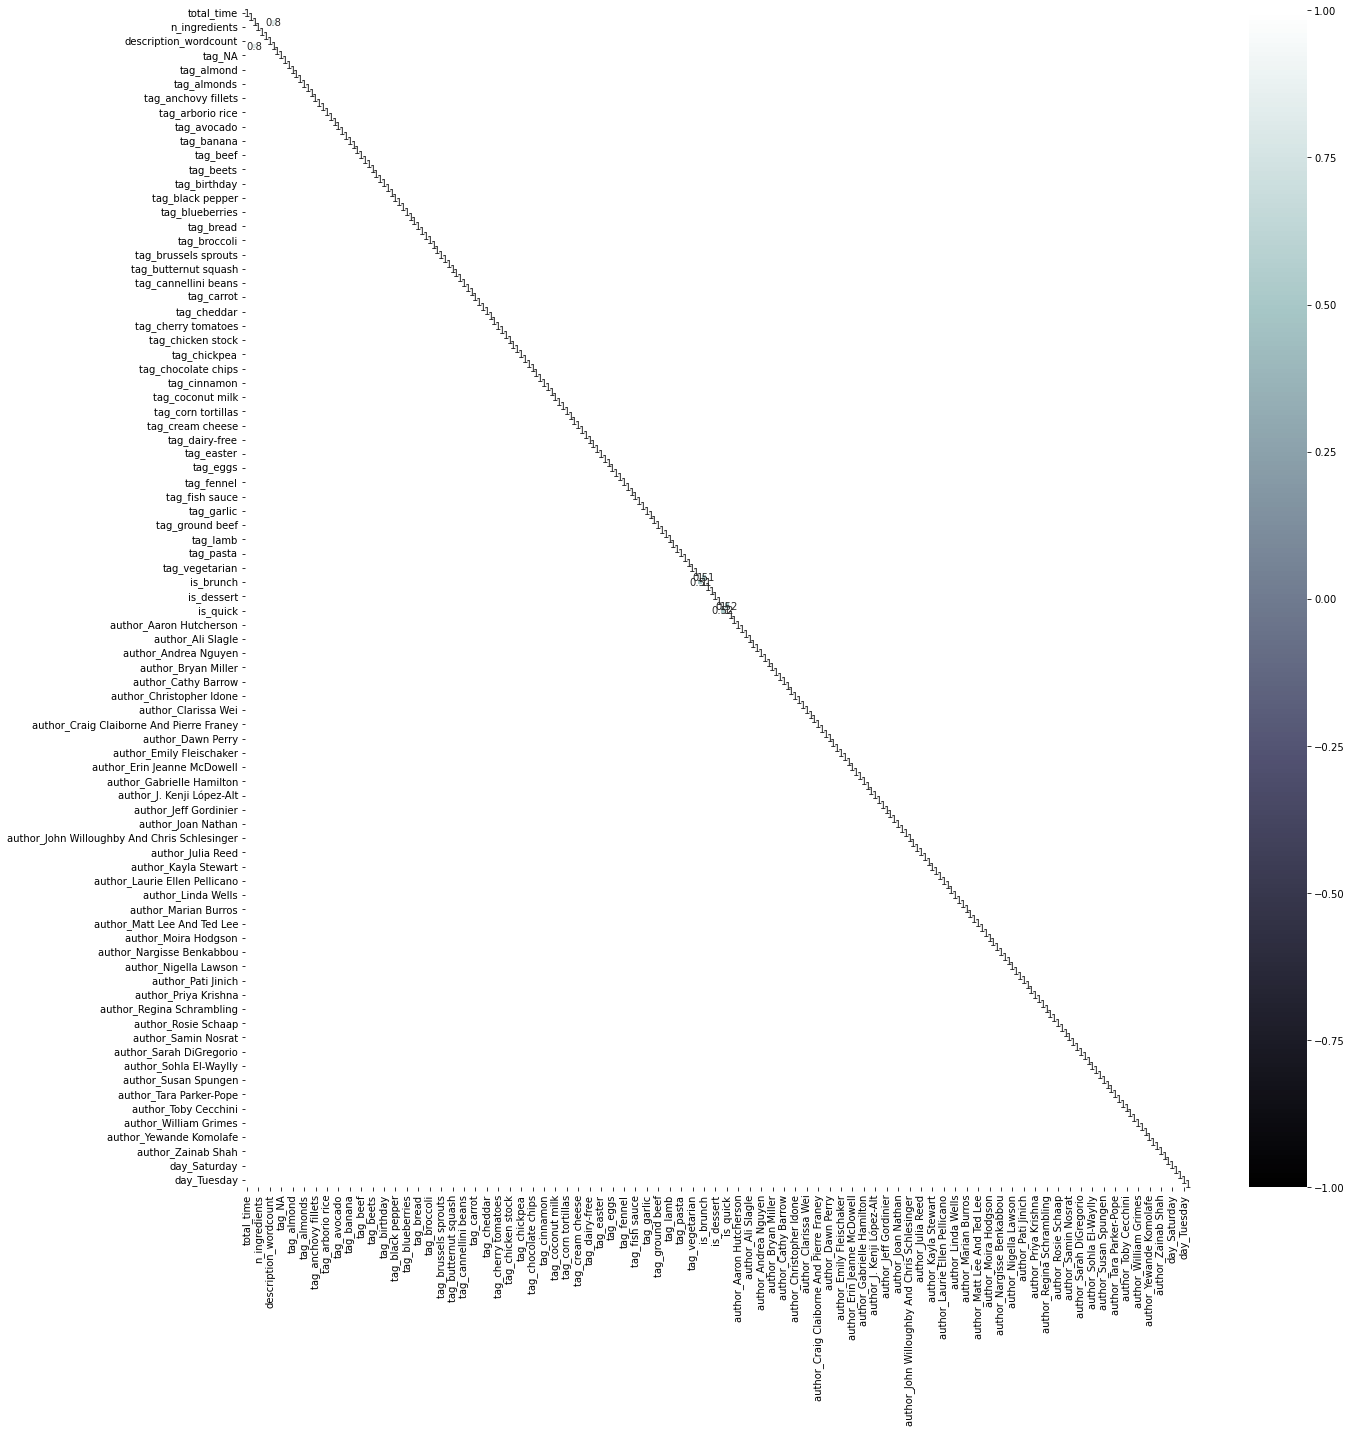

In [46]:
recipes_corr = recipes.corr()

recipes_corr_high = recipes_corr[recipes_corr >= 0.5]

plt.figure(figsize = (20,20))
sns.heatmap(recipes_corr_high,
            annot = True,
            vmin = -1,
            vmax = 1,
            cmap = 'bone');

plt.tight_layout();
plt.savefig('figures/recipes_corr.png',facecolor = 'white')

Surprisingly, there are not many highly correlated features here. For now, we'll keep all features in.

## Target variable
---

We'll be creating classification models to determine whether or not a NYT Cooking recipe is popular and produces a lot of traffic on the site. In order to do this, we'll need to define what is considered a heavily trafficked recipe. Two simple methods to do this would be to divide the recipes by mean or median. There are clearly outliers in our data and the target variable of number of ratings is heavily skewed. Outliers in this case are important, so we don't want to get rid of them. Since this is the case, we'll use median instead of mean to determine high traffic recipes.

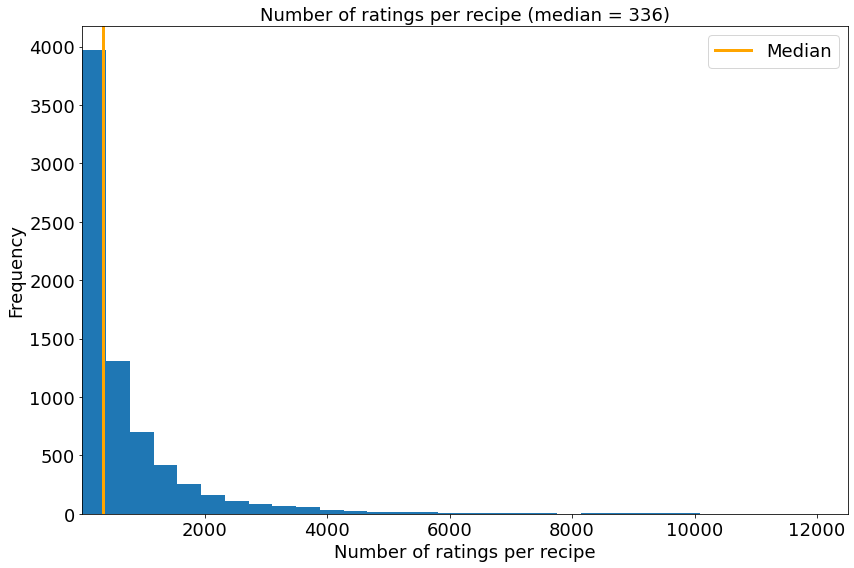

In [47]:
median = round(recipes['rating_count'].median())

plt.figure(figsize = (12,8))
plt.hist(recipes['rating_count'], bins=50)
plt.axvline(recipes['rating_count'].median(), color = 'orange', lw = 3, label = 'Median')
plt.xlabel('Number of ratings per recipe', fontsize = fsize)
plt.ylabel('Frequency', fontsize = fsize)
plt.title(f'Number of ratings per recipe (median = {median})', fontsize = fsize)
plt.xlim([1, 12500])
plt.legend(fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);
plt.tight_layout();
plt.savefig('figures/rating_count_median_hist.png',facecolor = 'white')

Normally distributed data is beneficial for model building. In this case, our target variable is not very normally distributed and is highly skewed. We can fix this a bit by taking the log of the rating count and using this to create our high_traffic target instead.

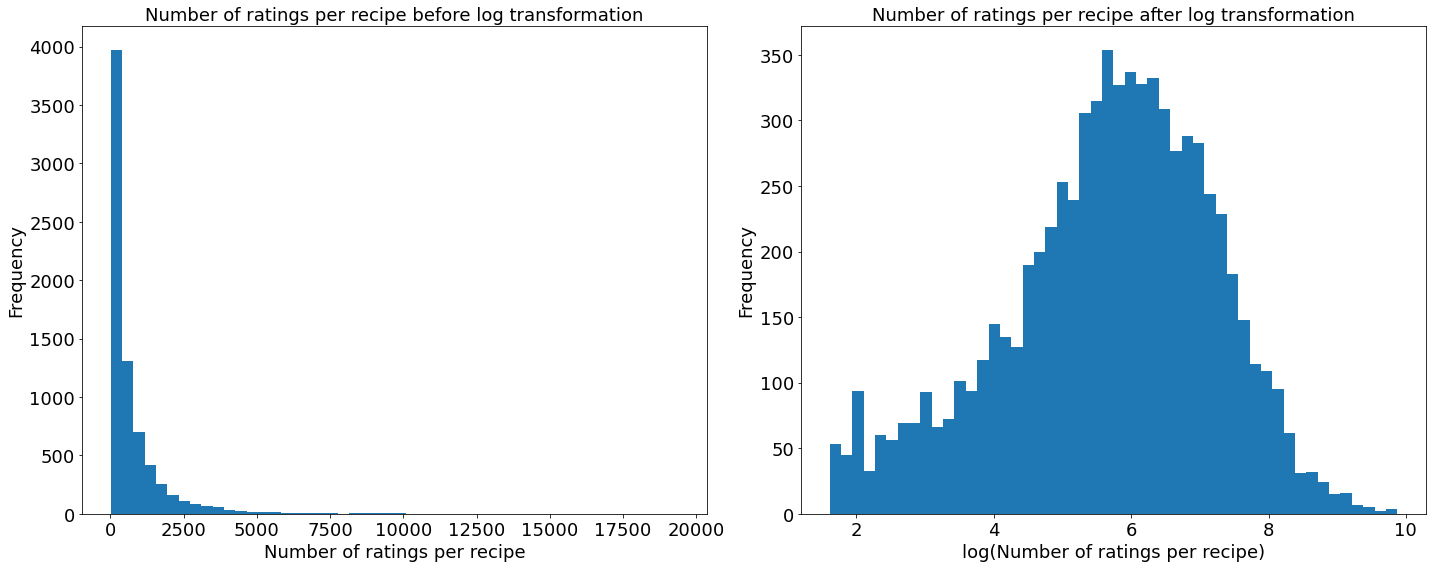

In [48]:
plt.figure(figsize = (20,8))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(recipes['rating_count'], bins=50)
ax1.set_xlabel('Number of ratings per recipe', fontsize = fsize)
ax1.set_ylabel('Frequency', fontsize = fsize)
plt.title('Number of ratings per recipe before log transformation', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

ax2 = plt.subplot(1, 2, 2)
ax2.hist(np.log(recipes['rating_count'],),bins=50)
ax2.set_xlabel('log(Number of ratings per recipe)', fontsize = fsize)
ax2.set_ylabel('Frequency', fontsize = fsize)
plt.title('Number of ratings per recipe after log transformation', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

plt.tight_layout();
plt.savefig('figures/rating_count_log_hists.png',facecolor = 'white')

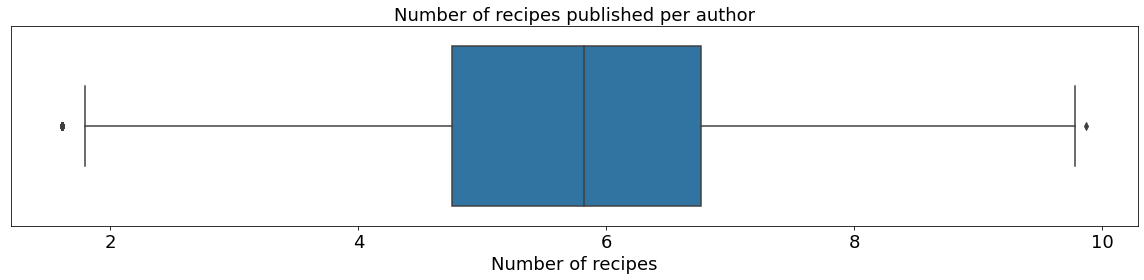

In [49]:
# There are a few extreme outliers in our data
plt.figure(figsize=(16,4))
sns.boxplot(data=np.log(recipes['rating_count']), orient='h')
plt.yticks([])
plt.xticks(fontsize = fsize)
#plt.xlim([0, 900])
plt.title('Number of recipes published per author', fontsize = fsize)
plt.xlabel('Number of recipes', fontsize = fsize);
plt.tight_layout();
plt.savefig('figures/recipes_per_author_boxplot.png',facecolor = 'white')

In [50]:
recipes['log_rating_count'] = np.log(recipes['rating_count'])

In [51]:
median_log = np.log(median)
recipes['high_traffic'] = recipes['log_rating_count'].apply(lambda x: 1 if x > median_log else 0)

This provides us with out baseline model: Predicting that a recipe will produce less than average traffic 50.01% of the time.

In [52]:
#BASELINE
recipes['high_traffic'].value_counts(normalize=True)
# Our baseline is predicting that a recipe will produce less than avg traffic 50.01% of the time

0    0.500137
1    0.499863
Name: high_traffic, dtype: float64

Lastly, before saving our results to a DataFrame, let's look at a heatmap of correlation to our target variable, rating count.

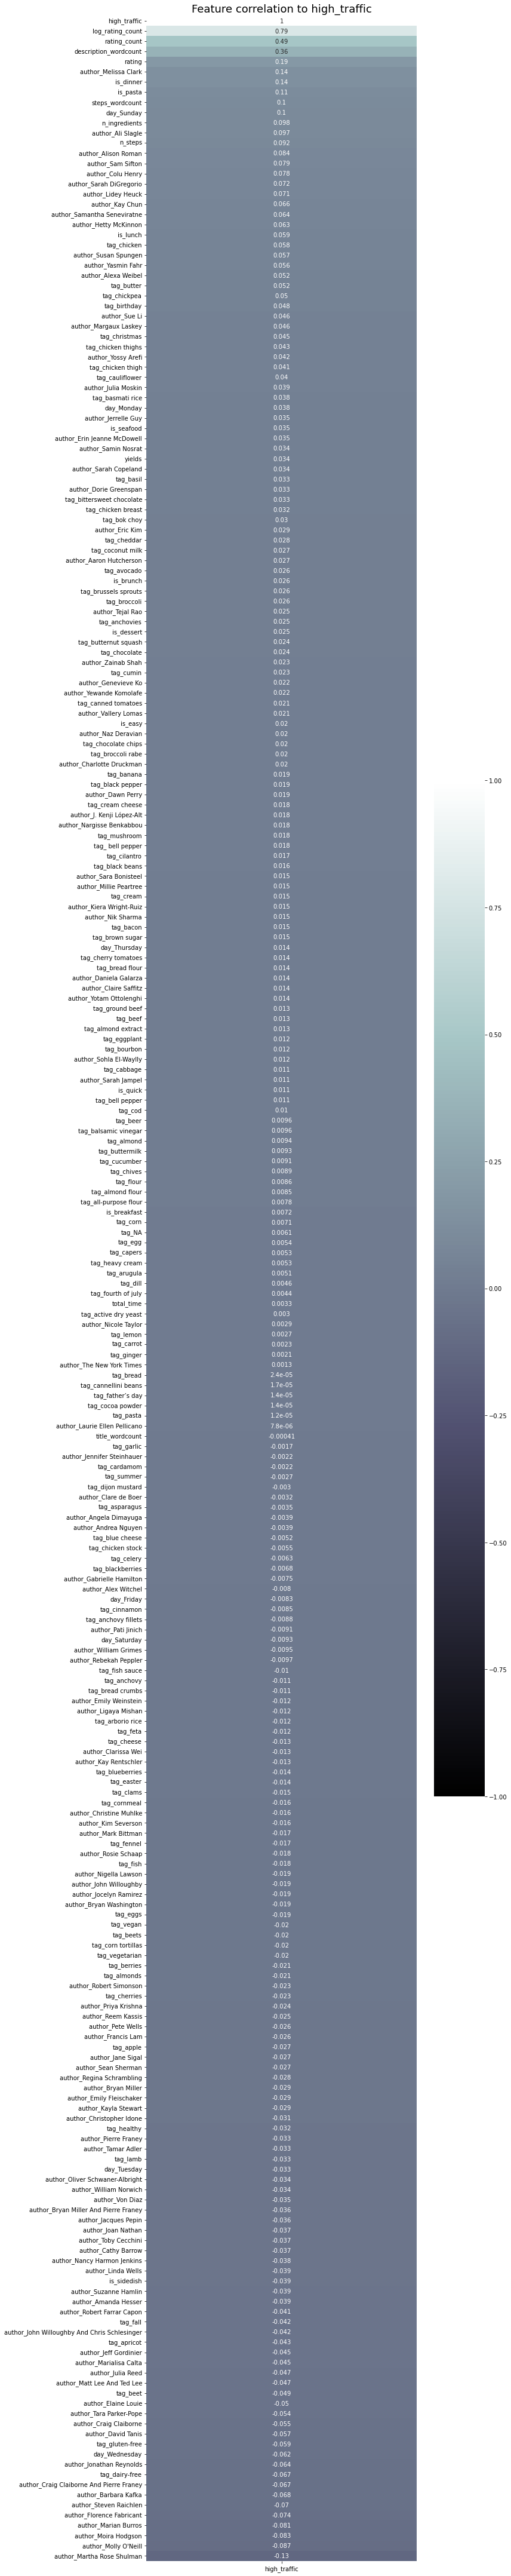

In [53]:
plt.figure(figsize=(12,60))
sns.heatmap(recipes.corr()[['high_traffic']].sort_values(by = 'high_traffic', ascending = False),
            annot = True,
            cmap = 'bone',
            vmin = -1,
            vmax = 1);
plt.title('Feature correlation to high_traffic', fontsize = fsize);
plt.tight_layout();
plt.savefig('figures/high_traffic_corr.png',facecolor = 'white')

As stated earlier, the rating itself is highly correlated with the amount of traffic a recipe receives. The question then becomes, what makes a better recipe?

Word count of the description apppears to be important. It also looks like dinner and pasta recipes are more popular. Certain authors, like Melissa Clark, Alison Roman and Ali Slagle, have many popular recipes. On the other hand, some authors, such as Martha Rose Shulman and Molly O'Neill, have a negative correlation to rating count. Dairy and gluten free recipes also have a negative correlation to recipe popularity. 

Lastly, we will save our final, cleaned data set for modeling.

In [54]:
#recipes.to_csv('data/recipes_final_df.csv')